In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../src'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/home/enis/projects/nna/src


In [3]:
import csv 
from pathlib import Path
from os import listdir
import pickle

from labeling_utils import load_labels

import numpy as np
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import train_test_split
import pandas as pd

tags=["Songbird","Water Bird","Insect","Running Water","Rain","Cable","Wind","Aircraft"]

from tabulate import tabulate
tag_set=tags[:]
import torch

%matplotlib inline

from torch.utils.data import Dataset, DataLoader


* Count only highest ranking tag (what if both of them exist)
* Bird tag is confusing, it can be also waterbird, how to handle ? Also Animal
* 

In [4]:
#LOAD MODEL predictions
splits_path= Path('/files/scratch/enis/data/nna/labeling/splits/')



In [5]:
import csv
from os import listdir
from pathlib import Path

# LOAD LABELS by human
labelsbyhumanpath=Path('/scratch/enis/data/nna/labeling/results/')
# filter csv extension also by username
labelsbyhuman=[i for i in listdir(labelsbyhumanpath) if (".csv" in i ) ]

humanresults={}
counter=0
for apath in labelsbyhuman:
    with open(labelsbyhumanpath / apath, newline='') as f:
        reader=csv.reader(f)
        for row in reader:
            counter+=1
            humanresults[row[0]]=row[1:]

print("unique files:",len(humanresults),"\ntotal files",counter)

#Join vehicle and Aircraft
for file_name,tagshere in humanresults.items():
#     print(file_name,tagshere)
    
    tagshere=["Aircraft" if tag == "Vehicle" else tag for tag in tags]

unique files: 1300 
total files 1366


In [6]:
# load name of the labels
labels=load_labels()

In [7]:
# returns a dictionary, keys are tags from tag set and values are binary list 
# 
def vectorized_y_true(humanresults,tag_set):
    y_true={tag: np.zeros(len(humanresults)) for tag in tag_set}
    for i,tags in enumerate(humanresults.values()):
        # we  only look for tags in tag_set
        for tag in tag_set:
            if tag in tags:
                y_true[tag][i] = 1
            else:
                y_true[tag][i] = 0 
    return y_true



In [8]:
y_true_dict = vectorized_y_true(humanresults,tags)
y_true_all = pd.DataFrame(y_true_dict)
y_true = np.array(y_true_all["Songbird"]).astype("long")


In [9]:
def map_reduce(X,func_type):
    if func_type=="Average":
        return np.mean(X,axis=1)
    elif func_type=="Concat":
        return np.reshape(X,(-1,1280))
    else:
        raise Exception("ERROR with embed type")

def pick_embed(embed_type):
    # humanresults[proc_embeds[0].replace("_embed.npy",".mp3")]
    X= np.empty((len(humanresults),10,128))
    for index,i in enumerate(humanresults):
        if embed_type=="Raw":
            file_name=i.replace(".mp3","_rawembed.npy")
        elif embed_type=="Normalized":
            file_name=i.replace(".mp3","_embed.npy")
        else:
            raise Exception("ERROR with embed type")
        an_x=np.load(split_path / file_name)
#         print(index,an_x)
        X[index,:,:]=an_x[:]
    return X

In [10]:

split_path=Path('/scratch/enis/data/nna/labeling/split_embeddings/')
# filter by username
split_embeds=[i for i in listdir(split_path) ]
raw_embeds =  [i for i in split_embeds if "rawembed" in i]
proc_embeds = [i for i in split_embeds if "_embed" in i]

In [11]:
X=pick_embed("Raw")
# X=map_reduce(X,map_reduce_type)
humanresults_keys=list(humanresults.keys())


In [12]:
X=X.astype("float32")

In [13]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
def cal_metrics(y_true_dict,y_pred_dict):
    results={}
    for tag in tag_set:
        y_true = y_true_dict[tag]
        y_pred = y_pred_dict[tag]
        metrics=precision_recall_fscore_support(y_true, y_pred,pos_label=1,average="binary")
        results[tag]=(metrics)
    return results

def cal_auc(y_true_dict,y_pred_dict_prob):
    results={}
    for tag in tag_set:
        y_true = y_true_dict[tag]
        y_pred = y_pred_dict_prob[tag]
        metrics_auc=roc_auc_score(y_true, y_pred) #average_precision_score
        results[tag]=(metrics_auc)

    return results

def print_results(results,y_true_dict,):
    headers= ["Label","Positive","Precision","Recall","Fscore"]
    table=[]
    sample_count=len(next(iter(y_true_dict.values())))
    print("Total sample:",sample_count,"And threshold is",prob_threshold)
    for tag in (tag_set):
        positive_count=sum(y_true_dict[tag])
        table.append([tag,positive_count,*results[tag][:-1]])

    print(tabulate(table, headers=headers))

    

In [14]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device="cpu"

In [15]:
def augment_data(data,augmentad_size):
    if data.shape[0]>=augmentad_size:
        return data[:]
    
    # Augment post samples
    augmentad = data[:]
    while augmentad.shape[0] < augmentad_size:
        left=augmentad_size-augmentad.shape[0]
        left= augmentad.shape[0] if left>augmentad.shape[0] else left
#         left = 2 if left==1 else left 
#         print(augmentad.shape[0],left)
        new=np.empty((left,augmentad.shape[1],augmentad.shape[2]))
#         print(torch.randperm(augmentad.shape[0])[:left])
        first,second=augmentad[torch.randperm(augmentad.shape[0])[:left],:,:].reshape(-1,10,128),augmentad[torch.randperm(augmentad.shape[0])[:left],:,:].reshape(-1,10,128)
#         print(first.shape,second.shape)
        new[:,0:5,:],new[:,5:10,:]=first[:,0:5,:],second[:,5:10,:]
        augmentad=np.concatenate([augmentad,new])
    #     print(augmentad.shape)
        augmentad=np.unique(augmentad,axis=0)
    #     print(augmentad.shape)
    return augmentad

#### Run only one of the following cells that does splitting 

In [434]:
# MEAN, AUGMENTAD entire dataset including test and validate

pos_index= (y_true==1)
neg_index= (y_true==0)


X_shuffled = X[:,torch.randperm(X.shape[1]),:]

X_shuffled_pos=X_shuffled[pos_index,:,:]
X_shuffled_neg=X_shuffled[neg_index,:,:]

augmentad_pos=augment_data(X_shuffled_pos,2000)

augmentad_neg=augment_data(X_shuffled_neg,2000)


X_augmented=np.concatenate([augmentad_pos,augmentad_neg]).astype("float32")
y_true_aug=np.concatenate([np.ones(augmentad_pos.shape[0]),np.zeros(augmentad_neg.shape[0])]).astype("int64")



MULTI_SEGMENT = False
X_augmented_mean=X_augmented.mean(axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_augmented_mean, y_true_aug, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

# X_train=X_train.reshape(X_train.shape[0],-1,128)
# X_test=X_test.reshape(X_test.shape[0],-1,128)
# X_val=X_val.reshape(X_test.shape[0],-1,128)


In [573]:
# AUGMENTATION Experiment
# from "Shuffling and Mixing Data Augmentation for Environmental Sound Classification" by Tadanobu Inoue et. al

MULTI_SEGMENT = False
FLAT=False

X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(X.shape[0],-1), y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

X_train=X_train.reshape(X_train.shape[0],-1,128)
X_test=X_test.reshape(X_test.shape[0],-1,128)
X_val=X_val.reshape(X_test.shape[0],-1,128)



pos_index= (y_train==1)
neg_index= (y_train==0)

# shuffle each sample sound within itself, granularity is 1 second, samples are 10 second
# so change order of seconds
X_shuffled = X_train[:,torch.randperm(X_train.shape[1]),:]
# no shuffle
# X_shuffled = X_train[:,:,:]

X_shuffled_pos=X_shuffled[pos_index,:,:]
X_shuffled_neg=X_shuffled[neg_index,:,:]

augmentation_ratio=1.2
augmentation_ratio=(1/augmentation_ratio)
augmentad_pos=augment_data(X_shuffled_pos,int(X_shuffled_pos.shape[0]//augmentation_ratio))
# augmentad_neg=augment_data(X_shuffled_neg,int(X_shuffled_neg.shape[0]//augmentation_ratio))
augmentad_neg=augment_data(X_shuffled_neg,X_shuffled_neg.shape[0])


X_train_augmented=np.concatenate([augmentad_pos,augmentad_neg]).astype("float32")
y_train_aug=np.concatenate([np.ones(augmentad_pos.shape[0]),np.zeros(augmentad_neg.shape[0])]).astype("int64")

X_train=X_train_augmented[:]
y_train=y_train_aug[:]

X_train=X_train.mean(axis=1)
X_test=X_test.mean(axis=1)
X_val=X_val.mean(axis=1)


In [536]:
# concat inputs
MULTI_SEGMENT = False
FLAT=True
X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(X.shape[0],-1), y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

X_train=X_train.reshape(X_train.shape[0],-1,128)
X_test=X_test.reshape(X_test.shape[0],-1,128)
X_val=X_val.reshape(X_test.shape[0],-1,128)


(2.4, 2.0)

In [516]:
# MEAN
MULTI_SEGMENT = False
FLAT=False

X_train, X_test, y_train, y_test = train_test_split(
    X_mean, y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

# X_train=X_train.reshape(X_train.shape[0],-1,128)
# X_test=X_test.reshape(X_test.shape[0],-1,128)
# X_val=X_val.reshape(X_test.shape[0],-1,128)


(1300, 1280)

In [16]:
# BEST model came from this cell

# seperate,  
# different AUC calculation PART, to be fair  (do max of 10 predictions)
MULTI_SEGMENT = True
FLAT=False

X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(X.shape[0],-1), y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

# use 1 second as  samples
X_train=X_train.reshape(-1,128)
X_test=X_test.reshape(-1,128)
X_val=X_val.reshape(-1,128)

# repeat labels
y_train=np.repeat(y_train,10)
y_test=np.repeat(y_test,10)
y_val=np.repeat(y_val,10)




### From here, run all cells: moving data to device, model creation and training

In [17]:
X_train=torch.from_numpy(X_train).to(device)
X_test=torch.from_numpy(X_test).to(device)
X_val=torch.from_numpy(X_val).to(device)
# birds

y_val=torch.from_numpy(y_val).to(device)
y_test=torch.from_numpy(y_test).to(device)
y_train=torch.from_numpy(y_train).to(device)


In [18]:
class audioDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,X,y, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X=X
        self.y=y
#         self.landmarks_frame = pd.read_csv(csv_file)
#         self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):

        sample = self.X[idx],self.y[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [19]:
params = {'batch_size': 200,
          'shuffle': True,
          'num_workers': 0}

training_set=audioDataset(X_train,y_train)
training_generator = DataLoader(training_set, **params)


In [300]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
        if FLAT:
            self.fc1 = nn.Linear(1280, 100)
        else:
            self.fc1 = nn.Linear(128, 100)
#         self.fc1 = nn.Linear(128, 32)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc1_bn = nn.BatchNorm1d(100)

        self.fc2 = nn.Linear(32, 32)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc2_bn = nn.BatchNorm1d(32)

        self.fc3 = nn.Linear(32,100)
        torch.nn.init.xavier_normal_(self.fc3.weight)
        self.fc3_bn = nn.BatchNorm1d(100)

        self.fc4 = nn.Linear(100, 2)
        torch.nn.init.xavier_normal_(self.fc4.weight)

        self.drop = nn.Dropout(p=0.2)
 
    def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
        if FLAT:
            x = x.view(-1,1280)
        else:
            x = x.view(-1,128)

        x = F.relu(self.fc1_bn(self.fc1(x)))
#         x = F.relu((self.fc1(x)))

        x=self.drop(x)

#         x = F.relu(self.fc2_bn(x))
#         x=self.drop(x)
        
#         x = F.relu(self.fc3(x))
#         x=self.drop(x)

        x = self.fc4(x)
#         print(x)
        x = F.log_softmax(x,dim=1)
#         print(x)
        return x


net = Net().to(device)
loss_values={"test":[],"train":[],"train_auc":[],"test_auc":[]}



In [301]:
import torch.optim as optim

#cross-entropy loss is sklearn one
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0,5.0]).to(device))
criterion = nn.CrossEntropyLoss()

# criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(),weight_decay=0.001)

In [302]:
import copy

In [303]:
from IPython import display
import time
best_acc1=0

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(training_generator, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         print(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
#         print(inputs.shape)
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
#         running_loss += loss.item()
#     if epoch % 20 == 0:    # print every 2000 mini-batches
    net.eval()
    test_loss,test_auc=nogradmetrics(X_val,y_val,net,multi_segment=MULTI_SEGMENT)
    train_loss,train_auc=nogradmetrics(X_train,y_train,net,multi_segment=MULTI_SEGMENT)
    net.train()
    loss_values["test"].append(test_loss)
    loss_values["train"].append(train_loss)
    loss_values["test_auc"].append(test_auc)
    loss_values["train_auc"].append(train_auc)
    if epoch % 20 == 0:    # print every 2000 mini-batches
        print('[%d] test : %.3f train: %.3f  test auc%.3f  train auc%.3f' %
              (epoch ,test_loss, train_loss,test_auc,train_auc))
    is_best = test_auc > best_acc1
    best_acc1 = max(test_auc, best_acc1)
    if is_best:
        best_model=copy.deepcopy(net)
    
#         display.clear_output(wait=True)
#         display.display(results.plot())
print('Finished Training')



[0] test : 0.537 train: 0.528  test auc0.866  train auc0.867
[20] test : 0.608 train: 0.456  test auc0.880  train auc0.948
[40] test : 0.566 train: 0.357  test auc0.881  train auc0.980
[60] test : 0.721 train: 0.400  test auc0.880  train auc0.980
[80] test : 0.735 train: 0.350  test auc0.872  train auc0.993
Finished Training


In [306]:
best_acc1

0.89744341073914

In [310]:
# save best model, change name accordingly, by adding validation accuracy
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

torch.save(best_model.state_dict(), "../../data/models/bird_FC_089valid_"+timestr+".pth")


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2f2031cf28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2effd02550>)

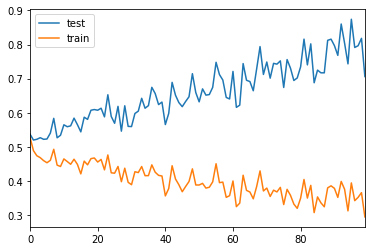

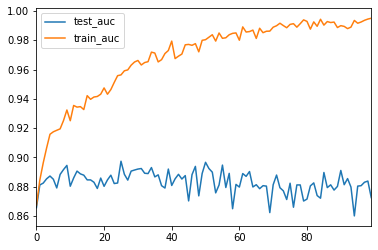

In [312]:
# visualize results
results=pd.DataFrame(loss_values)
results[["test","train"]].plot(),results[["test_auc","train_auc"]].plot(),

In [311]:
# results on test dataset, loss and AUC
nogradmetrics(X_test,y_test,best_model,multi_segment=MULTI_SEGMENT)

(0.6671180725097656, 0.8443587662337662)

In [ ]:
test_set=audioDataset(X_test,y_test)
test_generator = DataLoader(test_set, **params)


Following linse are for comparing sklearn MLP and this model

In [189]:
X_last=X[:]
# X_last=X_last.reshape(X_last.shape[0],-1)
X_last=X_last.reshape(-1,128)
X_last_sklearn=X_last[:]
X_last=torch.from_numpy(X_last).to(device)


In [ ]:
X_last.shape

In [190]:
y_pred_10.shape,y_test_10.shape

(torch.Size([1300, 2]), torch.Size([260]))

In [213]:
X_val.shape,y_val.shape

(torch.Size([2600, 128]), torch.Size([2600]))

In [214]:
best_model.eval()
with torch.no_grad():    
    
    y_pred = best_model(X_val)
    y_pred_10 =y_pred.reshape(-1,10,2)
    indices=torch.max(y_pred[:,1].reshape(-1,10),dim=1).indices
    y_pred_10 = y_pred_10[range(y_pred_10.shape[0]),indices,:].reshape(-1,2)

    y_val_10 = torch.max(y_val.reshape(-1,10),dim=1).values

#     loss = criterion(y_pred_10, y_true)

    train_auc=roc_auc_score(y_val_10.cpu().numpy(),
                            y_pred_10[:,1].cpu().numpy()) 
    print(train_auc)


0.8961980807266867


In [217]:
y_pred=y_pred_10.cpu()
y_pred=torch.exp(y_pred[:,1])
y_pred[y_pred>=0.5]=1
y_pred[y_pred<0.5]=0


In [220]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp=confusion_matrix(y_val_10.cpu().numpy(), y_pred).ravel()
tn, fp, fn, tp
(164, 23, 21, 52)
    sklearn  pytorch
tp   52       68
fp   23       67
tn   164      120
fn   21       5



(120, 67, 5, 68)

In [195]:
total=0
for i,mm in enumerate(y_true):
    predict= 1 if y_pred[i]>0.5 else 0 
    if mm!=predict:
        total+=1
        print(humanresults_keys[i])
print(total)

CLVL2_20160621_050750_1067m_07s__1067m_17s.mp3
CLVL5_20160713_100125_0784m_00s__0784m_10s.mp3
ITKILLIK1_20160819_082421_2235m_04s__2235m_14s.mp3
ITKILLIK1_20160727_135107_0345m_59s__0346m_09s.mp3
USGS_20160624_080838_0479m_03s__0479m_13s.mp3
CLVL2_20160604_153809_1807m_40s__1807m_50s.mp3
ITKILLIK1_20160712_105557_2581m_02s__2581m_12s.mp3
OCNPT_20160626_214658_1736m_09s__1736m_19s.mp3
ROCKY_20160608_204941_0183m_27s__0183m_37s.mp3
UMIAT_20130904_115811_2140m_25s__2140m_35s.mp3
ITKILLIK2_20160728_171820_2060m_22s__2060m_32s.mp3
CLVL2_20160721_184410_2000m_11s__2000m_21s.mp3
CLVL4_20160703_020906_0928m_38s__0928m_48s.mp3
ITKILLIK1_20160704_041106_1278m_24s__1278m_34s.mp3
ICERD_20160806_010352_2408m_48s__2408m_58s.mp3
ICERD_20160822_143323_2206m_12s__2206m_22s.mp3
FSHCK3_20160720_115157_0759m_10s__0759m_20s.mp3
CLVL5_20160606_195535_1100m_07s__1100m_17s.mp3
OCNPT_20160802_201449_0863m_32s__0863m_42s.mp3
FSHCK3_20160701_204040_0980m_34s__0980m_44s.mp3
FSHCK3_20160712_050656_0785m_01s__0785m

#### compare with sklearn

In [171]:
import pickle

# and later you can load it
with open('../Visualizations/raw_many2one_NN.pkl', 'rb') as f:
    clf = pickle.load(f)

In [172]:
def many2one_predict(X,clf):
    
    result_count=(X.shape[0]//10) if X.shape[0]%10==0 else (X.shape[0]//10)+1
    results=np.empty(result_count)
    for i in range(0,X.shape[0],10):
        result10=clf.predict(X[i:i+10,:])
        results[(i//10)] = np.max(result10)
    return results

In [196]:
X_last_sklearn.shape

(13000, 128)

In [205]:
#TEST
samples=np.ones((200,128))
y_pred_sklearn=many2one_predict(X_val.cpu().numpy(),clf['Neural Net_Songbird'])

In [221]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp=confusion_matrix(y_val_10.cpu().numpy(), y_pred_sklearn).ravel()
tn, fp, fn, tp

(164, 23, 21, 52)

In [203]:
total=0
for i,mm in enumerate(y_true):
    predict= 1 if y_pred[i]>0.5 else 0 
    predict_sklearn=int(y_pred_sklearn[i])
    if mm!=predict and mm==1:
        total+=1
        print(humanresults_keys[i],mm,predict,predict_sklearn)
print(total)

CLVL2_20160604_153809_1807m_40s__1807m_50s.mp3 1 0 0
CLVL5_20160606_195535_1100m_07s__1100m_17s.mp3 1 0 0
OCNPT_20160626_214658_0865m_02s__0865m_12s.mp3 1 0 0
USGS_20160618_030453_1287m_34s__1287m_44s.mp3 1 0 0
SHORTY_20160619_042858_2563m_41s__2563m_51s.mp3 1 0 0
OCNPT3_20160615_005046_0813m_58s__0814m_08s.mp3 1 0 0
FSHCK3_20160720_115157_1777m_41s__1777m_51s.mp3 1 0 0
UMIRUK_20160621_083400_0515m_46s__0515m_56s.mp3 1 0 0
FSHCK4_20160629_194935_0237m_49s__0237m_59s.mp3 1 0 0
ITKILLIK1_20160710_091444_0974m_18s__0974m_28s.mp3 1 0 0
CLVL2_20160715_134031_0935m_28s__0935m_38s.mp3 1 0 0
FSHCK3_20160706_000310_2407m_12s__2407m_22s.mp3 1 0 0
ITKILLIK2_20160626_172259_2184m_56s__2185m_06s.mp3 1 0 0
FSHCK1_20160808_050938_0344m_36s__0344m_46s.mp3 1 0 0
ICERD_20160824_161434_0373m_50s__0374m_00s.mp3 1 0 0
CLVL2_20160715_134031_2759m_40s__2759m_50s.mp3 1 0 0
USGS_20160609_201955_0289m_57s__0290m_07s.mp3 1 0 0
CLVL4_20160701_002747_2710m_53s__2711m_03s.mp3 1 0 0
UMIAT_20130727_224356_0077m_01s__

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

In [187]:
def nogradloss(X_test,y_test):
    with torch.no_grad():    
        outputs_test = net(X_test)
        loss = criterion(outputs_test, y_test)
        return loss.item()

def nogradmetrics(X_test,y_test,net,multi_segment=False):
    with torch.no_grad():    
        if not multi_segment:
            y_pred = net(X_test)
#             print(y_pred.shape)
#             print(y_pred[1:5,:])
    #         print(y_pred)
            loss = criterion(y_pred, y_test)
    #         print(y_pred)
            y_pred=torch.exp(y_pred)

    #         _, predicted = torch.min(y_pred,1)
    #         print(np.exp(_.cpu().numpy()),predicted)
            #         print(y_test.shape,y_pred.shape)
            train_auc=roc_auc_score(y_test.cpu().numpy(),
                                    y_pred[:,1].cpu().numpy()) 
            
            return loss.item(),train_auc
        else:
            y_pred = net(X_test)
            
            y_pred_10 =y_pred.reshape(-1,10,2)
            indices=torch.max(y_pred[:,1].reshape(-1,10),dim=1).indices
            y_pred_10 = y_pred_10[range(y_pred_10.shape[0]),indices,:].reshape(-1,2)
            
            y_test_10 = torch.max(y_test.reshape(-1,10),dim=1).values
            
            loss = criterion(y_pred_10, y_test_10)
            train_auc=roc_auc_score(y_test_10.cpu().numpy(),
                                    y_pred_10[:,1].cpu().numpy()) 
            return loss.item(),train_auc
            

In [411]:
np.exp([-6.7866, -4.4634])
F.softmax(torch.Tensor([0.5403, 0.4597]),dim=0),torch.exp(F.log_softmax(torch.Tensor([ 0.1147, -0.0307]),dim=0))

(tensor([0.5201, 0.4799]), tensor([0.5363, 0.4637]))